# Testing SmollVLM 1.7B

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv
import json
import torch

from transformers import AutoProcessor, AutoModelForVision2Seq
from tqdm import trange
from scripts.dataset import Dataset

print(f"Cuda is available: {torch.cuda.is_available()}")
sns.set_theme(palette=sns.color_palette("rocket_r"))

Cuda is available: True


In [2]:
CURRENT_PATH = os.getcwd()

DATASET_PATH = os.path.join(CURRENT_PATH, "dataset.csv")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Trainig Parameters
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNEL = 3

# LLM Prediction
CHECKPOINT_PATH = os.path.join(CURRENT_PATH, "report-smolvlm-1_7B.csv")
CM_PATH = os.path.join(CURRENT_PATH, "confusion_matrix_smolvlm-1_7B.png")
TABLE_PATH = os.path.join(CURRENT_PATH, "results_smolvlm-1_7B.txt")

In [3]:
assert os.path.isfile(DATASET_PATH), "Dataset not exists. Please run the previous notebook."
test_dataset = Dataset(dataset_path=DATASET_PATH, dataset_mode="csv", partition_name="test", preload=True, shuffle=False)

[LOG] Importing data from c:\Users\limag\projects\si\vlm_garbage_classification\dataset.csv, mode = csv
[LOG] Filtered by partition = test
[LOG] Preloading the dataset


100%|██████████| 253/253 [00:00<00:00, 1014.84it/s]


In [4]:
def as_numpy(dataset: Dataset):
    n = len(dataset)
    iterator = iter(dataset)
    x = np.ndarray(shape=(n, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), dtype=np.float64)
    y = np.ndarray(shape=(n,), dtype=np.int8)
    names = np.ndarray(shape=(n,), dtype=object)
    for index in trange(n):
        xi, yi, image_name = next(iterator)
        xi = cv.resize(xi, [IMAGE_WIDTH, IMAGE_HEIGHT])
        x[index] = xi
        y[index] = yi
        names[index] = image_name
    return x, y, names

x_test, y_test, names = as_numpy(test_dataset)
print(f"Image Shape = {x_test[0].shape}")

100%|██████████| 253/253 [00:00<00:00, 2795.68it/s]

Image Shape = (224, 224, 3)


## Preparing the LLM

In [5]:
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

c:\Users\limag\.conda\envs\deep_learning\lib\site-packages\transformers\models\auto\modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


In [6]:
def get_prompt_classification(prompt: str):
    prompt = prompt.split("Assistant")[-1]
    prompt = prompt.replace(",", "")
    prompt = prompt.replace(".", "")
    prompt = prompt.replace(";", "")
    prompt = prompt.replace(":", "")
    for word in prompt.split(" "):
        word = word.lower().strip()
        if word in test_dataset.classes:
            return test_dataset.encode_label(word)
    return 0

def generate_zeroshot_prompt(x: np.array):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Is this a glass, a cardboard, a plastic, a metal, a trash or a paper?"}
            ]
        },
    ]

    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[x], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts[0]

def generate_fewshot_prompt(x: np.array):
    prompt = """ 
    Choose one of them. Description of each possible type of material: 
    
    Cardboard = Thick, layered, textured material typically used in boxes or cartons. Often brown but may be printed or colored. Rigid and not easily crumpled like paper.
    Metal = Shiny or dull gray, rigid items such as cans, foil, lids, or caps. May show dents, rust, or corrosion. Hard and does not bend easily by hand.
    Plastic = Lightweight, smooth, often glossy items such as bottles, bags, containers, or wrappers. Can be clear or brightly colored, flexible or rigid. Does not absorb water.
    Glass = Transparent or translucent containers such as bottles or jars. Smooth surface, can shatter into sharp edges when broken. Often heavier than plastic.
    Paper = Thin sheets that are flat, flexible, and easy to tear or crumple. May have writing, printing, or drawings on them (e.g., office paper, newspapers, magazines).
    Trash = Mixed or non-recyclable waste such as food scraps, dirty or contaminated items, or composite materials made of multiple layers (e.g., chip bags, soiled napkins).
    
    Which material is this?
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]
        },
    ]

    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[x], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts[0]

# index = 2
# prompt = generate_fewshot_prompt(x_test[index])
# print(prompt)
# prediction = get_prompt_classification(prompt)
# print(test_dataset.decode_label(prediction))
# print(test_dataset.decode_label(y_test[index]))
# plt.imshow(x_test[index].astype(np.int64))
# plt.axis("off")
# plt.show()

In [7]:
assert not os.path.isfile(CHECKPOINT_PATH), f"{CHECKPOINT_PATH} already exists."

y_pred = np.ndarray(shape=y_test.shape, dtype=np.int8)
checkpoint = {
    "image_name": [],
    "y_true": [],
    "y_pred": [],
    "y_true_as_str": [],
    "y_pred_as_str": [],
    "prompt": [],
}

# Iterate over the test dataset
for index in trange(len(x_test)):
    xi = x_test[index]
    yi = y_test[index]
    name = names[index]
    
    # Prediction...
    # prompt = generate_zeroshot_prompt(xi)
    prompt = generate_fewshot_prompt(xi)
    prediction = get_prompt_classification(prompt)
    
    # Saving results
    y_pred[index] = prediction
    
    # Saving checkpoint
    checkpoint["image_name"].append(name)
    checkpoint["y_true"].append(yi)
    checkpoint["y_pred"].append(prediction)
    checkpoint["y_true_as_str"].append(test_dataset.decode_label(yi))
    checkpoint["y_pred_as_str"].append(test_dataset.decode_label(prediction))
    checkpoint["prompt"].append(prompt.replace("\n", " "))
    pd.DataFrame.from_dict(checkpoint).to_csv(CHECKPOINT_PATH, sep=";", index=False)

100%|██████████| 253/253 [03:59<00:00,  1.06it/s]


## Evaluating the model

In [8]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from prettytable import PrettyTable

def plot_metrics(y_true: np.array, y_pred: np.array):
    table = PrettyTable(["Metric", "Value (%)"])
    
    # Calculating metrics...
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0.0) * 100

    table.add_row(['Accuracy', f"{accuracy:.2f}%"])
    table.add_row(['Precision', f"{precision:.2f}%"])
    table.add_row(['Recall', f"{recall:.2f}%"])
    table.add_row(['F1 Score', f"{f1:.2f}%"])
    
    print(table)
    with open(TABLE_PATH, "w+") as results_file:
        results_file.write(str(table))

def plot_cm(y_true: np.array, y_pred: np.array):
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_true, y_pred)
    plt.title(f'Confusion Matrix')
    sns.heatmap(cm, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True), fmt='.0f', yticklabels=test_dataset.classes, xticklabels=test_dataset.classes)
    plt.savefig(CM_PATH)
    plt.show()

+-----------+-----------+
|   Metric  | Value (%) |
+-----------+-----------+
|  Accuracy |   54.55%  |
| Precision |   62.68%  |
|   Recall  |   50.68%  |
|  F1 Score |   48.70%  |
+-----------+-----------+


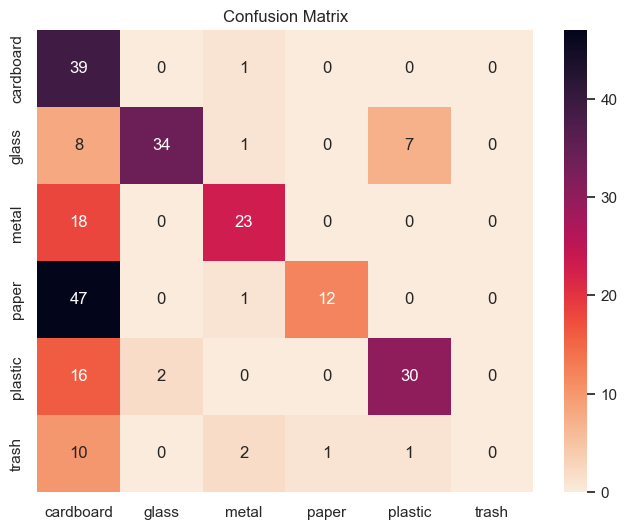

In [9]:
plot_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

Visualizing some errors

In [10]:
errors = []
for index in range(len(y_pred)):
    true = y_test[index] 
    pred = y_pred[index]
    if true != pred:
        errors.append((x_test[index], true, pred))

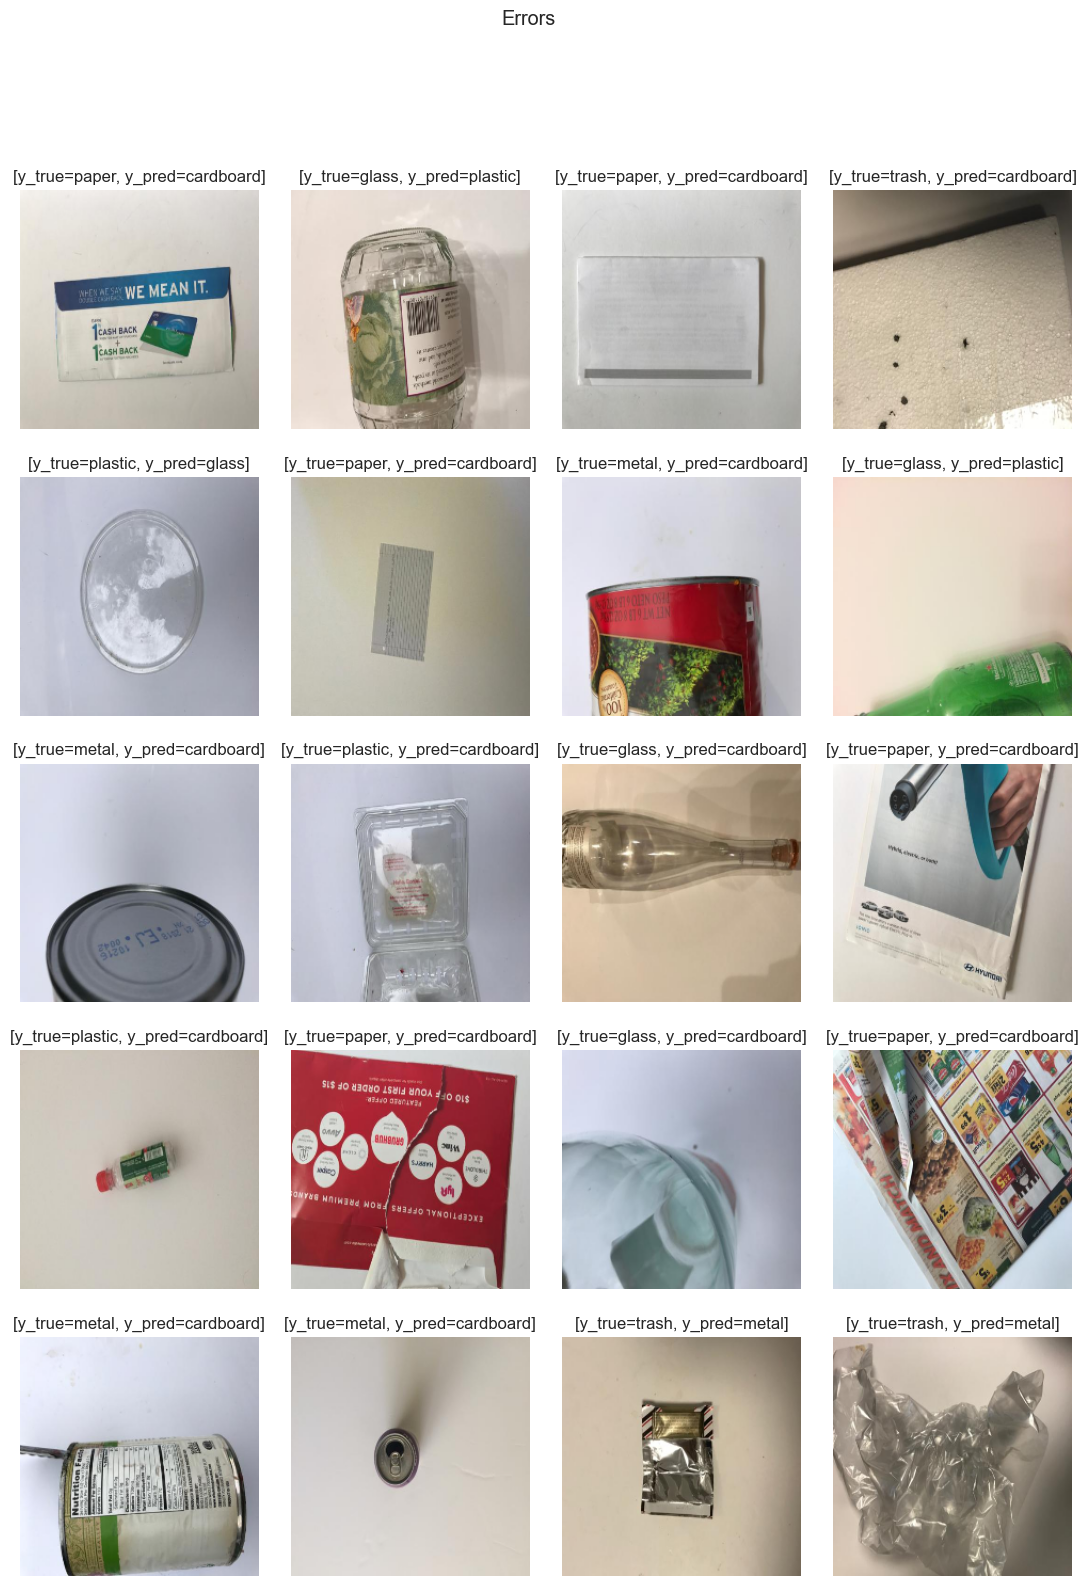

In [11]:
nrows = 5
ncols = 4

figure, axis = plt.subplots(nrows, ncols, squeeze=False, figsize=(14,18))
figure.suptitle(f"Errors")
axes = []
for ax in axis:
    axes += [*ax]
for index in range(nrows * ncols):
    ax = axes[index]
    x, true_class, pred = errors[index]
    pred = test_dataset.decode_label(pred)
    true_class = test_dataset.decode_label(true_class)
    ax.axis("off")
    ax.set_title(f"[y_true={true_class}, y_pred={pred}]")
    ax.imshow(x.astype(np.int64))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()